# Current Algorithm

Junita Sirait

In [1]:
import json
import csv
import pandas as pd
import numpy as np
import statistics

import tldextract

from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn import preprocessing

from sklearn.metrics import silhouette_score
from sklearn import metrics
from kneed import KneeLocator

from scipy.interpolate import make_interp_spline, BSpline

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

import math

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold

import os

<a id="sub1"></a>
## Subreddit data

In [2]:
pd1 = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd1,"data/gm-newssources-subreddits")
dfp = os.path.join(pd1,"data")
mbfc_path = os.path.join(pd1, "data/mbfc")

In [3]:
with open (os.path.join(dfp,"gm_intersection.json"), "r", encoding = "utf-8") as infile:
    gm_intersection = json.load(infile)

In [4]:
len(gm_intersection)

42477

In [5]:
# Reading in all the subreddits in our files

with open(os.path.join(data_fp,"subreddit_ns_2021-01.json"), "r", encoding = "utf-8") as infile1a:
    subreddit_ns_jan = json.load(infile1a)

with open(os.path.join(data_fp,"subreddit_ns_2021-02.json"), "r", encoding = "utf-8") as infile2a:
    subreddit_ns_feb = json.load(infile2a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-03.json"), "r", encoding = "utf-8") as infile3a:
    subreddit_ns_march = json.load(infile3a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-04.json"), "r", encoding = "utf-8") as infile4a:
    subreddit_ns_april = json.load(infile4a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-05.json"), "r", encoding = "utf-8") as infile5a:
    subreddit_ns_may = json.load(infile5a)
    
with open(os.path.join(data_fp,"subreddit_ns_2021-06.json"), "r", encoding = "utf-8") as infile6a:
    subreddit_ns_jun = json.load(infile6a)

In [6]:
# ns_subreddit
with open(os.path.join(data_fp,"ns_subreddit_2021-01.json")) as infile1:
    ns_subreddit_01 = json.load(infile1)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-02.json")) as infile2:
    ns_subreddit_02 = json.load(infile2)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-03.json")) as infile3:
    ns_subreddit_03 = json.load(infile3)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-04.json")) as infile4:
    ns_subreddit_04 = json.load(infile4)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-05.json")) as infile5:
    ns_subreddit_05 = json.load(infile5)
    
with open(os.path.join(data_fp,"ns_subreddit_2021-06.json")) as infile6:
    ns_subreddit_06 = json.load(infile6)

In [7]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [8]:
sr_union_old = (set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

In [9]:
len(sr_union_old)

1619721

## Removing `u_`s

In [10]:
u_s = [s for s in sr_union_old if s.startswith("u_")]
len(u_s)

910554

In [11]:
u_s[:5]

['u_dooormattt22',
 'u_beachbabe2040',
 'u_WeAtHeR_FoReCaSt_228',
 'u_Ancient_Supermarket1',
 'u_that_one_guy4343']

In [12]:
for f in files_sub:
    [f.pop(u) for u in u_s if u in f]

In [13]:
sr_union_old = (set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))
len(sr_union_old)

709167

Removing "reddit.com" and non_news from files_sub

In [14]:
non_news = []
with open("non_news.csv", "r", encoding="utf-8") as nn:
    r = csv.reader(nn, delimiter=",")
    counter = 0
    for row in r:
        if counter != 0:
            non_news.append(row[0])
        counter += 1
len(non_news)

133

In [15]:
for f in files_sub:
    for n in f:
        if 'reddit.com' in f[n]: f[n].pop('reddit.com')
        # removing each of the non_news
        for nns in non_news:
            if nns in f[n]: f[n].pop(nns)
    print("Done for a file")

Done for a file
Done for a file
Done for a file
Done for a file
Done for a file
Done for a file


Now that we have removed non_news from various subreddits, there would be subreddits that now does not have anything inside. Let's get rid of these subreddits as well.

In [16]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [17]:
for s in files_sub:
    empty_subs = set()
    for k in s:
        if len(s[k]) == 0: empty_subs.add(k)
    print(len(empty_subs))
    [s.pop(u) for u in empty_subs]
    print("done for a file")

184122
done for a file
184876
done for a file
204204
done for a file
210956
done for a file
247878
done for a file
264114
done for a file


In [18]:
for f in files_sub:
    [f.pop(u) for u in empty_subs if u in f]
    print("done for a file")

done for a file
done for a file
done for a file
done for a file
done for a file
done for a file


Instead of removing from files_ns, I will reconstruct files_ns from files_sub.

In [19]:
def ns_from_sub(subfile):
    d = defaultdict(dict)
    for sub in subfile:
        for n in subfile[sub]:
            d[n][sub] = subfile[sub][n]
    return d

In [20]:
ns_subreddit_01 = ns_from_sub(subreddit_ns_jan)
ns_subreddit_02 = ns_from_sub(subreddit_ns_feb)
ns_subreddit_03 = ns_from_sub(subreddit_ns_march)
ns_subreddit_04 = ns_from_sub(subreddit_ns_april)
ns_subreddit_05 = ns_from_sub(subreddit_ns_may)
ns_subreddit_06 = ns_from_sub(subreddit_ns_jun)

In [21]:
"reddit.com" in ns_subreddit_01

False

Let's use the intersection in an alphabetical order as a fixed order of our subreddits.

In [22]:
subs = sorted(set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

In [23]:
len(subs)

10016

## Intersections and unions of subreddits

In [24]:
# what about their intersection?
sr_intersection = (
      set(subreddit_ns_jan) & set(subreddit_ns_feb) &
      set(subreddit_ns_march) & set(subreddit_ns_april) &
      set(subreddit_ns_may) & set(subreddit_ns_jun))

print("intersection:", len(sr_intersection))

intersection: 10016


In [25]:
sr_union = (
      set(subreddit_ns_jan) | set(subreddit_ns_feb) |
      set(subreddit_ns_march) | set(subreddit_ns_april) |
      set(subreddit_ns_may) | set(subreddit_ns_jun))

print("union:", len(sr_union))

union: 42895


<a id="sub2"></a>
## News sources data

How many news sources are there?

In [26]:
# union
ns_union = (set(ns_subreddit_01) |
       set(ns_subreddit_02) |
       set(ns_subreddit_03) |
       set(ns_subreddit_04) |
       set(ns_subreddit_05) |
       set(ns_subreddit_06))

len(ns_union)

23417

In [27]:
nss = (set(ns_subreddit_01) &
       set(ns_subreddit_02) &
       set(ns_subreddit_03) &
       set(ns_subreddit_04) &
       set(ns_subreddit_05) &
       set(ns_subreddit_06))

In [28]:
num_ns = len(nss)
num_ns

8663

In [29]:
"u_toronto_news" in subreddit_ns_jan

False

In [30]:
len(subreddit_ns_jan)

18712

## For each news source, let's count in how many subreddits they appear

In [31]:
subreddit_count = dict()
for ns in ns_union:
    subreddit_count[ns] = len(set(ns_subreddit_01.get(ns, dict()).keys()) 
                               | set(ns_subreddit_02.get(ns, dict()).keys()) 
                               | set(ns_subreddit_03.get(ns, dict()).keys()) 
                               | set(ns_subreddit_04.get(ns, dict()).keys())
                               | set(ns_subreddit_05.get(ns, dict()).keys()) 
                               | set(ns_subreddit_06.get(ns, dict()).keys()))

`subreddit_count` stores in how many subreddits each news source appears.

In [32]:
subreddit_count['nytimes.com']

5439

In [33]:
subreddit_count_freq = dict(Counter(subreddit_count.values()).most_common())
subreddit_count_freq

{1: 4708,
 2: 2787,
 3: 1947,
 4: 1390,
 5: 1111,
 6: 906,
 7: 774,
 8: 651,
 9: 511,
 10: 477,
 11: 429,
 12: 373,
 13: 344,
 14: 318,
 15: 295,
 16: 257,
 17: 245,
 18: 214,
 21: 189,
 19: 187,
 20: 180,
 22: 170,
 24: 144,
 27: 129,
 25: 128,
 23: 127,
 28: 111,
 30: 103,
 29: 99,
 26: 99,
 33: 99,
 32: 96,
 37: 91,
 31: 83,
 35: 82,
 34: 76,
 46: 72,
 36: 69,
 40: 66,
 44: 65,
 43: 65,
 41: 64,
 42: 63,
 39: 61,
 38: 58,
 45: 56,
 49: 55,
 48: 50,
 53: 49,
 47: 48,
 56: 44,
 54: 44,
 51: 44,
 52: 43,
 55: 42,
 67: 42,
 50: 40,
 73: 38,
 68: 33,
 60: 32,
 59: 31,
 57: 30,
 63: 30,
 62: 30,
 64: 29,
 80: 28,
 61: 28,
 66: 27,
 58: 27,
 69: 25,
 71: 25,
 84: 25,
 72: 25,
 86: 24,
 65: 23,
 83: 23,
 74: 23,
 75: 22,
 92: 21,
 79: 21,
 85: 21,
 70: 21,
 82: 21,
 81: 20,
 89: 20,
 90: 19,
 87: 19,
 110: 19,
 76: 19,
 102: 19,
 99: 18,
 98: 17,
 78: 17,
 91: 16,
 96: 15,
 121: 15,
 111: 15,
 109: 15,
 77: 15,
 104: 14,
 116: 14,
 144: 14,
 103: 14,
 101: 14,
 133: 13,
 88: 13,
 95: 12,
 1

`subreddit_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [34]:
max(subreddit_count_freq.keys())

5618

In [35]:
sde_ranked = Counter(subreddit_count).most_common()

for t in sde_ranked[:20]:
    sr, co = t
    if co > 1:
        print(f"{sr} is mentioned in {co} subreddits.")

theguardian.com is mentioned in 5618 subreddits.
nytimes.com is mentioned in 5439 subreddits.
cnn.com is mentioned in 5006 subreddits.
bbc.com is mentioned in 4241 subreddits.
reuters.com is mentioned in 3906 subreddits.
washingtonpost.com is mentioned in 3692 subreddits.
forbes.com is mentioned in 3488 subreddits.
cnbc.com is mentioned in 3358 subreddits.
bloomberg.com is mentioned in 3269 subreddits.
apnews.com is mentioned in 3084 subreddits.
businessinsider.com is mentioned in 3026 subreddits.
bbc.co.uk is mentioned in 2972 subreddits.
npr.org is mentioned in 2907 subreddits.
nbcnews.com is mentioned in 2816 subreddits.
independent.co.uk is mentioned in 2728 subreddits.
msn.com is mentioned in 2699 subreddits.
dailymail.co.uk is mentioned in 2693 subreddits.
vice.com is mentioned in 2581 subreddits.
nypost.com is mentioned in 2442 subreddits.
wsj.com is mentioned in 2409 subreddits.


In [36]:
sum(subreddit_count_freq.values()) == len(ns_union)

True

In [37]:
import itertools

In [38]:
scf = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in subreddit_count_freq.items()))

Text(0.5, 1.0, 'number of news sources appearing in x subreddits')

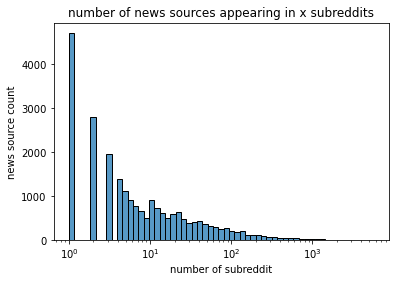

In [39]:
# sns.histplot([math.log(s,10) for s in scf])
sns.histplot(scf, log_scale=True)
plt.xlabel("number of subreddit")
plt.ylabel("news source count")
plt.title("number of news sources appearing in x subreddits")

How many news sources only appear in 10 subreddits or less? what about 9 or 8?

In [40]:
def pct_ns_in_k_subreddits(ks):
    ns_in_i_subreddit = [k for k in subreddit_count if subreddit_count[k] <= ks]
    count = len(ns_in_i_subreddit)
    print("There are {} news sources appearing in only {} subreddits or less ({}%)".format(count, ks, count/len(ns_union)))
    return count/len(ns_union)

In [41]:
pct_ns_in_k_subreddits(5)

There are 11943 news sources appearing in only 5 subreddits or less (0.5100140923260879%)


0.5100140923260879

In [42]:
0.15*len(ns_union)

3512.5499999999997

In [43]:
pct_in_k_subreddits = [(i, pct_ns_in_k_subreddits(i)) for i in range(1000)]

There are 0 news sources appearing in only 0 subreddits or less (0.0%)
There are 4708 news sources appearing in only 1 subreddits or less (0.20105051885382413%)
There are 7495 news sources appearing in only 2 subreddits or less (0.3200666182687791%)
There are 9442 news sources appearing in only 3 subreddits or less (0.4032113421872998%)
There are 10832 news sources appearing in only 4 subreddits or less (0.46256992783020884%)
There are 11943 news sources appearing in only 5 subreddits or less (0.5100140923260879%)
There are 12849 news sources appearing in only 6 subreddits or less (0.5487039330400991%)
There are 13623 news sources appearing in only 7 subreddits or less (0.5817568433189563%)
There are 14274 news sources appearing in only 8 subreddits or less (0.6095571593286928%)
There are 14785 news sources appearing in only 9 subreddits or less (0.6313789127556904%)
There are 15262 news sources appearing in only 10 subreddits or less (0.6517487295554512%)
There are 15691 news sources 

There are 22584 news sources appearing in only 160 subreddits or less (0.9644275526327027%)
There are 22592 news sources appearing in only 161 subreddits or less (0.9647691847802878%)
There are 22597 news sources appearing in only 162 subreddits or less (0.9649827048725285%)
There are 22601 news sources appearing in only 163 subreddits or less (0.965153520946321%)
There are 22604 news sources appearing in only 164 subreddits or less (0.9652816330016655%)
There are 22612 news sources appearing in only 165 subreddits or less (0.9656232651492506%)
There are 22614 news sources appearing in only 166 subreddits or less (0.9657086731861468%)
There are 22620 news sources appearing in only 167 subreddits or less (0.9659648972968357%)
There are 22623 news sources appearing in only 168 subreddits or less (0.96609300935218%)
There are 22630 news sources appearing in only 169 subreddits or less (0.966391937481317%)
There are 22634 news sources appearing in only 170 subreddits or less (0.96656275355

There are 23252 news sources appearing in only 596 subreddits or less (0.9929538369560575%)
There are 23253 news sources appearing in only 597 subreddits or less (0.9929965409745057%)
There are 23254 news sources appearing in only 598 subreddits or less (0.9930392449929538%)
There are 23255 news sources appearing in only 599 subreddits or less (0.993081949011402%)
There are 23255 news sources appearing in only 600 subreddits or less (0.993081949011402%)
There are 23255 news sources appearing in only 601 subreddits or less (0.993081949011402%)
There are 23257 news sources appearing in only 602 subreddits or less (0.9931673570482983%)
There are 23257 news sources appearing in only 603 subreddits or less (0.9931673570482983%)
There are 23257 news sources appearing in only 604 subreddits or less (0.9931673570482983%)
There are 23257 news sources appearing in only 605 subreddits or less (0.9931673570482983%)
There are 23257 news sources appearing in only 606 subreddits or less (0.9931673570

There are 23285 news sources appearing in only 686 subreddits or less (0.9943630695648461%)
There are 23285 news sources appearing in only 687 subreddits or less (0.9943630695648461%)
There are 23285 news sources appearing in only 688 subreddits or less (0.9943630695648461%)
There are 23286 news sources appearing in only 689 subreddits or less (0.9944057735832942%)
There are 23286 news sources appearing in only 690 subreddits or less (0.9944057735832942%)
There are 23286 news sources appearing in only 691 subreddits or less (0.9944057735832942%)
There are 23286 news sources appearing in only 692 subreddits or less (0.9944057735832942%)
There are 23286 news sources appearing in only 693 subreddits or less (0.9944057735832942%)
There are 23286 news sources appearing in only 694 subreddits or less (0.9944057735832942%)
There are 23286 news sources appearing in only 695 subreddits or less (0.9944057735832942%)
There are 23286 news sources appearing in only 696 subreddits or less (0.9944057

There are 23303 news sources appearing in only 777 subreddits or less (0.9951317418969124%)
There are 23303 news sources appearing in only 778 subreddits or less (0.9951317418969124%)
There are 23303 news sources appearing in only 779 subreddits or less (0.9951317418969124%)
There are 23303 news sources appearing in only 780 subreddits or less (0.9951317418969124%)
There are 23305 news sources appearing in only 781 subreddits or less (0.9952171499338087%)
There are 23305 news sources appearing in only 782 subreddits or less (0.9952171499338087%)
There are 23305 news sources appearing in only 783 subreddits or less (0.9952171499338087%)
There are 23305 news sources appearing in only 784 subreddits or less (0.9952171499338087%)
There are 23306 news sources appearing in only 785 subreddits or less (0.9952598539522569%)
There are 23307 news sources appearing in only 786 subreddits or less (0.995302557970705%)
There are 23307 news sources appearing in only 787 subreddits or less (0.99530255

There are 23324 news sources appearing in only 872 subreddits or less (0.9960285262843234%)
There are 23325 news sources appearing in only 873 subreddits or less (0.9960712303027714%)
There are 23325 news sources appearing in only 874 subreddits or less (0.9960712303027714%)
There are 23325 news sources appearing in only 875 subreddits or less (0.9960712303027714%)
There are 23325 news sources appearing in only 876 subreddits or less (0.9960712303027714%)
There are 23325 news sources appearing in only 877 subreddits or less (0.9960712303027714%)
There are 23325 news sources appearing in only 878 subreddits or less (0.9960712303027714%)
There are 23325 news sources appearing in only 879 subreddits or less (0.9960712303027714%)
There are 23326 news sources appearing in only 880 subreddits or less (0.9961139343212196%)
There are 23326 news sources appearing in only 881 subreddits or less (0.9961139343212196%)
There are 23326 news sources appearing in only 882 subreddits or less (0.9961139

There are 23344 news sources appearing in only 964 subreddits or less (0.9968826066532861%)
There are 23344 news sources appearing in only 965 subreddits or less (0.9968826066532861%)
There are 23344 news sources appearing in only 966 subreddits or less (0.9968826066532861%)
There are 23344 news sources appearing in only 967 subreddits or less (0.9968826066532861%)
There are 23344 news sources appearing in only 968 subreddits or less (0.9968826066532861%)
There are 23344 news sources appearing in only 969 subreddits or less (0.9968826066532861%)
There are 23344 news sources appearing in only 970 subreddits or less (0.9968826066532861%)
There are 23344 news sources appearing in only 971 subreddits or less (0.9968826066532861%)
There are 23345 news sources appearing in only 972 subreddits or less (0.9969253106717342%)
There are 23345 news sources appearing in only 973 subreddits or less (0.9969253106717342%)
There are 23345 news sources appearing in only 974 subreddits or less (0.9969253

[(0.0, 200.0)]

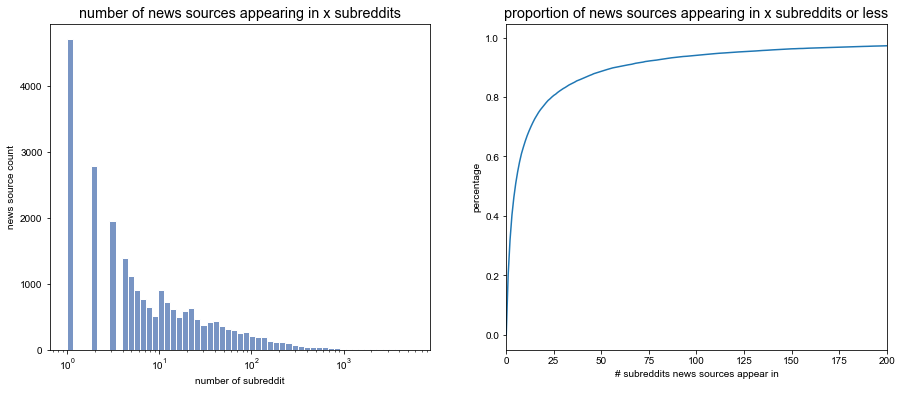

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
sns.set(font_scale = 1.2)

sns.histplot(scf, log_scale=True, ax=ax1)
ax1.set_xlabel("number of subreddit")
ax1.set_ylabel("news source count")
ax1.set_title("number of news sources appearing in x subreddits")

sns.lineplot(x=[k[0] for k in pct_in_k_subreddits],
             y=[k[1] for k in pct_in_k_subreddits],
            ax=ax2)
ax2.set_ylabel("percentage")
ax2.set_xlabel("# subreddits news sources appear in")
ax2.set_title("proportion of news sources appearing in x subreddits or less")
ax2.set(xlim = (0, 200))

In [45]:
# mean
statistics.mean(scf)

31.726352649784346

In [46]:
# median
statistics.median(scf)

5

## For each news source let's count how many times they are shared regardless of in which subreddits

In [47]:
sum(dict().values())

0

In [48]:
def get_mention_count(ns):
    """get total mention count of ns in all six months"""
    count = 0
    files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
    for f in files:
        ns_dict = f.get(ns, dict())
        if len(ns_dict) > 0:
            mentions = sum([m[0] for m in ns_dict.values()])
            count += mentions
    return count

In [49]:
mention_count = dict()
for ns in ns_union:
    mention_count[ns] = get_mention_count(ns)

In [50]:
statistics.mean(mention_count.values())

297.3964641072725

In [51]:
statistics.stdev(mention_count.values())

3822.4586591985976

In [52]:
statistics.median(mention_count.values())

10

In [53]:
len(mention_count)

23417

In [54]:
Counter(mention_count).most_common(20)

[('mlb.com', 318947),
 ('theguardian.com', 225905),
 ('cnn.com', 160434),
 ('nytimes.com', 144231),
 ('foxnews.com', 141788),
 ('thehindu.com', 88410),
 ('bbc.co.uk', 87886),
 ('thestar.com', 87662),
 ('reuters.com', 85020),
 ('nypost.com', 81591),
 ('cnbc.com', 65428),
 ('thehill.com', 63497),
 ('indiatimes.com', 63032),
 ('washingtontimes.com', 59941),
 ('breitbart.com', 57659),
 ('usatoday.com', 54142),
 ('scmp.com', 52531),
 ('cbc.ca', 52369),
 ('apnews.com', 48540),
 ('nbcnews.com', 48371)]

In [55]:
news_ge10k = [m for m in mention_count if mention_count[m] >= 1000]
len(news_ge10k)

803

<AxesSubplot:ylabel='Count'>

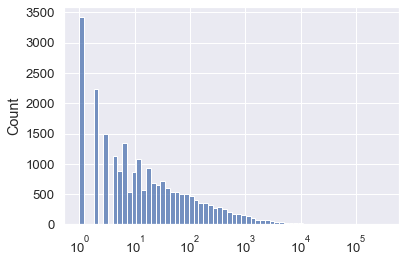

In [56]:
sns.histplot(list(mention_count.values()), log_scale=True)

<AxesSubplot:ylabel='Count'>

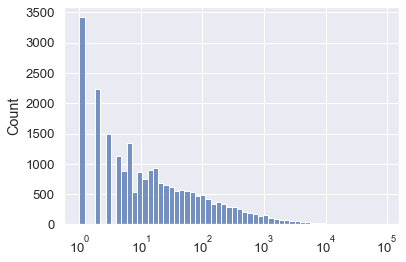

In [57]:
sns.histplot(list([k for k in mention_count.values() if k <100000]), log_scale=True)

In [58]:
len([k for k in mention_count.values() if k <5])*100/len(mention_count)

35.33757526583251

In [59]:
(1-0.35)*len(mention_count)

15221.050000000001

## For each subreddit let's count how many news sources were mentioned in it

Counting how many news sources were mentioned in each subreddit

In [60]:
nsc_count = dict()
for sr in sr_union:
    nsc_count[sr] = len(set(subreddit_ns_jan.get(sr, dict()).keys()) 
                               | set(subreddit_ns_feb.get(sr, dict()).keys()) 
                               | set(subreddit_ns_march.get(sr, dict()).keys()) 
                               | set(subreddit_ns_april.get(sr, dict()).keys())
                               | set(subreddit_ns_may.get(sr, dict()).keys()) 
                               | set(subreddit_ns_jun.get(sr, dict()).keys()))

`nsc_count` stores how many news sources appear in each subreddit.

In [61]:
len([k for k in nsc_count if nsc_count[k]<1])

0

In [62]:
nsc_count_freq = dict(Counter(nsc_count.values()).most_common())
nsc_count_freq

{1: 14979,
 2: 5025,
 3: 3027,
 4: 2157,
 5: 1616,
 6: 1455,
 7: 1083,
 8: 1040,
 9: 876,
 10: 752,
 11: 642,
 12: 558,
 13: 519,
 14: 476,
 15: 387,
 16: 376,
 18: 351,
 17: 341,
 19: 302,
 20: 298,
 22: 238,
 21: 233,
 24: 216,
 23: 209,
 25: 190,
 28: 178,
 27: 176,
 26: 176,
 29: 163,
 30: 150,
 32: 142,
 31: 129,
 33: 128,
 34: 118,
 36: 115,
 35: 112,
 39: 103,
 37: 101,
 40: 85,
 41: 85,
 38: 83,
 42: 79,
 44: 78,
 52: 76,
 43: 76,
 49: 68,
 48: 67,
 45: 66,
 47: 66,
 50: 65,
 51: 59,
 53: 59,
 55: 56,
 46: 53,
 58: 51,
 56: 51,
 59: 47,
 62: 42,
 63: 42,
 54: 41,
 61: 40,
 64: 38,
 60: 38,
 66: 36,
 77: 36,
 68: 36,
 65: 34,
 74: 32,
 67: 32,
 57: 31,
 70: 31,
 71: 29,
 72: 28,
 73: 28,
 80: 28,
 81: 26,
 69: 26,
 93: 26,
 79: 25,
 85: 25,
 86: 24,
 88: 24,
 82: 24,
 83: 24,
 76: 22,
 75: 22,
 94: 20,
 78: 20,
 91: 19,
 110: 19,
 89: 18,
 84: 18,
 103: 18,
 104: 18,
 97: 17,
 118: 17,
 87: 17,
 116: 17,
 141: 16,
 101: 16,
 112: 16,
 130: 15,
 102: 15,
 96: 15,
 111: 15,
 98: 1

`nsc_count_freq` keeps track of how many news sources appear in *n* subreddits for all possible *n*.

In [63]:
max(nsc_count_freq.keys())

3603

In [64]:
nsc_ranked = Counter(nsc_count).most_common()

for t in nsc_ranked:
    sr, co = t
    if co >= 80:
        print(f"{sr} has {co} news sources mentioned in it.")

COVID_CANADA has 3603 news sources mentioned in it.
news has 3451 news sources mentioned in it.
politics has 3043 news sources mentioned in it.
todayilearned has 2947 news sources mentioned in it.
Coronavirus has 2612 news sources mentioned in it.
worldnews has 2564 news sources mentioned in it.
nottheonion has 2444 news sources mentioned in it.
prisons has 2309 news sources mentioned in it.
NoFilterNews has 2254 news sources mentioned in it.
conspiracy has 2098 news sources mentioned in it.
wallstreetbets has 1997 news sources mentioned in it.
tomorrowsworld has 1877 news sources mentioned in it.
autotldr has 1754 news sources mentioned in it.
Conservative has 1728 news sources mentioned in it.
NoNewNormal has 1590 news sources mentioned in it.
CryptoCurrency has 1542 news sources mentioned in it.
technology has 1523 news sources mentioned in it.
europe has 1432 news sources mentioned in it.
electionReformNews has 1423 news sources mentioned in it.
HumanTraffickingNews has 1338 news s

In [65]:
sum(nsc_count_freq.values()) == len(sr_union)

True

In [66]:
import itertools

In [67]:
nsc = list(itertools.chain.from_iterable(itertools.repeat(k,v) for k,v in nsc_count_freq.items()))

Text(0.5, 1.0, 'number of subreddits with x news sources')

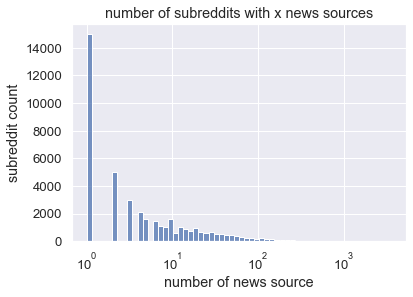

In [68]:
sns.histplot(nsc, log_scale=True)
plt.xlabel("number of news source")
plt.ylabel("subreddit count")
plt.title("number of subreddits with x news sources")

In [69]:
len([n for n in nsc if n>=20])

6933

How many subreddits only mentioned 5 news sources or less?

In [70]:
def pct_subreddits_mentioning_k_newssources(ks):
    sr_mention_i_nsc = [k for k in nsc_count if nsc_count[k] <= ks]
    count = len(sr_mention_i_nsc)
    print("There are {} subreddits mentioning in only {} news sources or less ({}%)".format(count, ks, count/len(sr_union)))
    return count/len(sr_union)

In [71]:
pct_subreddits_mentioning_k_newssources(20)

There are 36260 subreddits mentioning in only 20 news sources or less (0.8453199673621634%)


0.8453199673621634

In [72]:
# mean
statistics.mean(nsc)

17.31987411120177

In [73]:
# median
statistics.median(nsc)

3

In [74]:
(1-pct_subreddits_mentioning_k_newssources(100)) * len(nsc_count)

There are 41516 subreddits mentioning in only 100 news sources or less (0.9678517309709757%)


1378.9999999999993

### Let's disregard subreddits that mention less than 20 news sources

In [75]:
subreddit_non_outlier = [k for k in nsc_count if nsc_count[k] >= 100]

In [76]:
len(subreddit_non_outlier)

1391

## For each subreddit let's count total submissions that are news source related

In [77]:
def get_submission_count(sb):
    """get total mention count of ns in all six months"""
    count = 0
    files = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
    for f in files:
        sb_dict = f.get(sb, dict())
        if len(sb_dict) > 0:
            mentions = sum([m[0] for m in sb_dict.values()])
            count += mentions
    return count

In [78]:
mention_count = dict()
for sb in sr_union:
    mention_count[sb] = get_submission_count(sb)

In [79]:
statistics.mean(mention_count.values())

162.35302482806853

In [80]:
statistics.stdev(mention_count.values())

3243.8579307069776

In [81]:
statistics.median(mention_count.values())

5

In [82]:
len(mention_count)

42895

In [83]:
Counter(mention_count).most_common(20)

[('AutoNewspaper', 582301),
 ('politics', 136899),
 ('TheNewsFeed', 91784),
 ('news', 84656),
 ('TrendingQuickTVnews', 82824),
 ('COVID_CANADA', 76571),
 ('worldnews', 68589),
 ('Conservative', 53941),
 ('THEHINDUauto', 44130),
 ('niuz', 43845),
 ('NoFilterNews', 43261),
 ('nofeenews', 40684),
 ('TORONTOSTARauto', 39281),
 ('trendandstyle', 38133),
 ('CertifiedNews', 38011),
 ('WrestlingBreakingNews', 37277),
 ('FOXauto', 36228),
 ('NewsfeedForWork', 34863),
 ('Coronavirus', 34075),
 ('UKNewsByABot', 33001)]

In [84]:
ns_subreddit_01['cbc.ca']

{'todayilearned': [17, 14.780000000000001, 2038],
 'JoeRogan': [1, 0.76, 3],
 'knowyourshit': [3, 2.92, 1],
 'collapse': [7, 6.280000000000001, 58],
 'marginal': [3, 3.0, 0],
 'conspiracy': [11, 8.9, 649],
 'politics': [121, 107.37999999999998, 227661],
 'CPTSD': [1, 1.0, 1],
 'VideoEditing': [1, 0.98, 38],
 'wallstreetbets': [15, 13.129999999999999, 115],
 'hackernews': [8, 5.92, 8],
 'patient_hackernews': [8, 8.0, 8],
 'unitedkingdom': [2, 1.82, 19],
 'Catholicism': [1, 1.0, 2],
 'books': [6, 5.2, 15],
 'hackerdigest': [1, 1.0, 0],
 'Snorkblot': [2, 2.0, 2],
 'UnresolvedMysteries': [18, 17.439999999999998, 1033],
 'TrueUnpopularOpinion': [2, 1.3, 32],
 'SPACs': [2, 1.8, 152],
 'aznidentity': [1, 0.98, 40],
 'badgovnofreedom': [34, 34.0, 1],
 'cyberpunkgame': [1, 0.4, 3],
 'CBC_': [9, 8.84, 1],
 'newjersey': [1, 0.8, 25],
 'newfoundland': [28, 25.439999999999994, 406],
 'Hamilton': [42, 35.79, 950],
 'Oshawa': [1, 0.9, 5],
 'RedditTLDR': [5, 4.67, 1],
 'Sino': [1, 0.96, 18],
 'Sorcere

<AxesSubplot:ylabel='Count'>

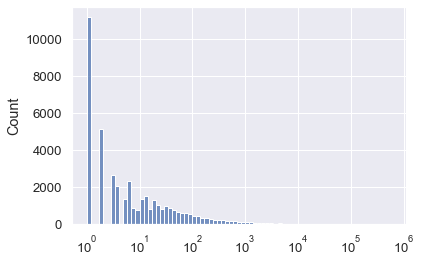

In [85]:
sns.histplot(list(mention_count.values()), log_scale=True)

In [86]:
len([k for k in mention_count.values() if k <5])*100/len(mention_count)

49.12227532346427

In [87]:
(1-0.35)*len(mention_count)

27881.75

In [88]:
non_outlier = [n for n in ns_union if subreddit_count[n]>50]
len(non_outlier)

2655

## Cluster Try Out

First, I make a list of subreddits with fixed order, where I only include subreddits where our non_outlier news sources are mentioned in.

In [89]:
len(non_outlier)

2655

In [90]:
# only intersection
len(set(non_outlier) & set(nss))

2639

In [91]:
non_outlier = list(set(non_outlier) & set(nss))

In [92]:
len(non_outlier)

2639

In [93]:
# subreddits = subs
subreddits = set()
nsr_files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
# first, I filter for only the subreddits in which our news sources are mentioned
c = 0
for n in non_outlier:
    subreddits = (subreddits | (set(ns_subreddit_01.get(n, dict()).keys()) 
                               & set(ns_subreddit_02.get(n, dict()).keys()) 
                               & set(ns_subreddit_03.get(n, dict()).keys()) 
                               & set(ns_subreddit_04.get(n, dict()).keys())
                               & set(ns_subreddit_05.get(n, dict()).keys()) 
                               & set(ns_subreddit_06.get(n, dict()).keys())))
    c += 1
    if c%100==0: print(f"done {c}")
subreddits = list(subreddits)
len(subreddits)

done 100
done 200
done 300
done 400
done 500
done 600
done 700
done 800
done 900
done 1000
done 1100
done 1200
done 1300
done 1400
done 1500
done 1600
done 1700
done 1800
done 1900
done 2000
done 2100
done 2200
done 2300
done 2400
done 2500
done 2600


3638

There are 4k subreddits.

In [94]:
len(set(subreddits) & set(subreddit_non_outlier))

1135

In [95]:
subreddits = list(set(subreddits) & set(subreddit_non_outlier))

In [96]:
subreddits[-10:]

['California_Politics',
 'Portland',
 'crime',
 'changemyview',
 'IntelligenceBooks',
 'oklahoma',
 'nCoV',
 'CrimesAgainstAsianity',
 'SaltyArmy',
 'arizonapolitics']

If I should order them later, I can do so.

## Incorporating subscribers information

In [97]:
pd1 = os.path.split(os.getcwd())[0]
data_fp = os.path.join(pd1,"data/gm-newssources-subreddits")
dfp = os.path.join(pd1,"data")

In [98]:
sfp = os.path.join(pd1,"data/subreddits")

In [99]:
# Let's only use the subreddits that have lots of subscribers
with open (os.path.join(sfp,"subreddit_subscribers.json"), "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [100]:
subreddit_subscribers['politics']

6201779

In [101]:
len(subreddit_subscribers)

49055

In [102]:
len(subreddits)

1135

In [103]:
subreddits_w_subc = [k for k in subreddits if k in subreddit_subscribers]
len(subreddits_w_subc)

1032

It seems that there are `None` values, so let's filter those subreddits out.

In [104]:
print([s for s in subreddits_w_subc if subreddit_subscribers[s] is None])

[]


In [105]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]

In [106]:
len(subreddits_w_subc)

1032

Now, I will sort the 8,294 subreddits based on the # of their subscribers in a descending order.

In [107]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

Text(0.5, 1.0, 'Subreddits Subscribers')

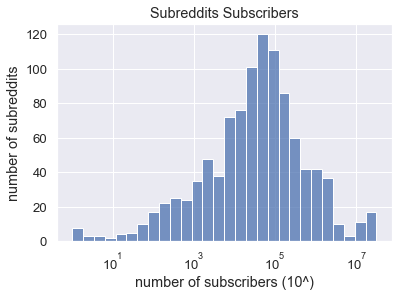

In [108]:
# plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])
sns.histplot([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s]>0], log_scale=True)
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
# plt.yscale("log")
# plt.xscale("log")
plt.ylabel("number of subreddits")
plt.xlabel("number of subscribers (10^)")
plt.title("Subreddits Subscribers")
# log scale for both x and y

Which subreddits are the top three?

In [109]:
print([(s,subreddit_subscribers[s]) for s in srs_all if subreddit_subscribers[s]>10000])

[('funny', 31060166), ('gaming', 26628444), ('pics', 24911449), ('science', 24268001), ('worldnews', 24253881), ('Music', 24041486), ('videos', 23114010), ('movies', 23087255), ('todayilearned', 23030716), ('news', 20935015), ('askscience', 19222916), ('books', 18078148), ('Art', 17826701), ('sports', 17292578), ('nottheonion', 17063313), ('space', 16937271), ('gadgets', 16890685), ('television', 16595714), ('UpliftingNews', 15926382), ('InternetIsBeautiful', 15019126), ('history', 14885003), ('philosophy', 14818794), ('Futurology', 14675526), ('dataisbeautiful', 14612638), ('personalfinance', 14176579), ('TwoXChromosomes', 12782590), ('memes', 10670593), ('technology', 9065541), ('WTF', 6224561), ('politics', 6201779), ('interestingasfuck', 5807636), ('travel', 4489082), ('leagueoflegends', 4184297), ('facepalm', 4046462), ('NatureIsFuckingLit', 3790070), ('pcmasterrace', 3722335), ('Whatcouldgowrong', 3569470), ('nba', 3310886), ('PS4', 3291344), ('photography', 2875552), ('programmi

In [110]:
list(subreddit_subscribers.values()).count(None)

25

In [111]:
statistics.median([k for k in list(subreddit_subscribers.values()) if k is not None])

1420.0

In [112]:
statistics.mean([k for k in list(subreddit_subscribers.values()) if k is not None])

50070.832184376915

## Building `ns_repr`

Which will be in the form of feature-based matrix, where each row represents a news source, and columns representing subreddits. 

Idea 1: Each subreddit will be represented by 18 columns: unweighted count, upvote based weighted count, and comment based weighted count for each of the six months that we are interested in. THIS does not work.

Idea 2: Each subreddit will be represented by 3 columns: average unweighted count, average upvote based weighted count, and average comment based weighted count.

In [113]:
srs = srs_all

In [114]:
a = {"a": 1, "b": 2}
b = {"b": 1, "c": 2}
res = {**a, **b}
res

{'a': 1, 'b': 1, 'c': 2}

Idea 1: For each news source, I create a list of length `(18 * # subreddits)`.

Idea 1: For each news source, I create a list of length `(3 * # subreddits)`

Old code
```
# here I will cast the inner dictionaries of ns_subreddits to be Counter so I can avoid a lot of if-else statements
files = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]
for f in files:
    for k in f: # k is each news source
        for ns in f[k]:
            # averaging based on weighted counts
            count, upv, comm = f[k][ns]
            avg = (upv + comm)/count
            f[k][ns] = avg
        f[k] = Counter(f[k])
```

In [115]:
files_sub = [subreddit_ns_jan, subreddit_ns_feb, subreddit_ns_march, subreddit_ns_april, subreddit_ns_may, subreddit_ns_jun]
files_ns = [ns_subreddit_01, ns_subreddit_02, ns_subreddit_03, ns_subreddit_04, ns_subreddit_05, ns_subreddit_06]

In [116]:
len(non_outlier)

2639

In [117]:
len(srs)

1032

I tried and found out that using all 23.7k subreddits results in MemoryError. So I should use less

In [118]:
srs = srs_all

For idea 1:

```
ns_sr_rep = defaultdict(list)
default_counter = Counter() # to avoid a lot of if else statements

ncount = 0

# for ns in nss:
for ns in non_outlier:
    # for each news sources, construct the 18*length(subreddits) features
    for f in files_sub:
        for idx in range(len(srs)):
            # making sure the ordering follows `srs` based on subscribers
            ns_sr_rep[ns] += f[ns][srs[idx]][1:] if (ns in f and srs[idx] in f[ns]) else [0, 0]
    ncount += 1
    if ncount%200==0: print(ncount)
```

In [369]:
# For idea 2

ns_sr_rep = defaultdict(list)
default_counter = Counter() # to avoid a lot of if else statements

ncount = 0

# for ns in nss:
for ns in ["nytimes.com"]:
    # for each news sources, construct the length(subreddits) features
    for idx in range(len(srs)):
        # making sure the ordering follows `srs` based on subscribers
        current_sr = srs[idx]
        avg_unweighted_counts = sum([ii[current_sr][ns][0] if current_sr in ii and ns in ii[current_sr] else 0 for ii in files_sub])
        avg_votebased_counts = sum([ii[current_sr][ns][1] if (current_sr in ii and ns in ii[current_sr]) else 0 for ii in files_sub])
        avg_commentbased_counts = sum([ii[current_sr][ns][2] if current_sr in ii and ns in ii[current_sr] else 0 for ii in files_sub])
        ns_sr_rep[ns] += [avg_votebased_counts, avg_commentbased_counts]
    ncount += 1
    if ncount%500==0: print(ncount)

In [375]:
srs[100:150]

['marvelstudios',
 'investing',
 'changemyview',
 'UnresolvedMysteries',
 'iamatotalpieceofshit',
 'CryptoCurrency',
 'childfree',
 'hockey',
 'Health',
 'PoliticalHumor',
 'google',
 'formula1',
 'techsupport',
 'Fantasy',
 'awfuleverything',
 'CFB',
 'PoliticalDiscussion',
 'privacy',
 'Economics',
 'ADHD',
 'Boxing',
 'stocks',
 'teslamotors',
 'Drugs',
 'Marvel',
 'environment',
 'canada',
 'FloridaMan',
 'FuckYouKaren',
 'psychology',
 'aviation',
 'fantasyfootball',
 'CasualUK',
 'business',
 'JoeRogan',
 'Piracy',
 'offbeat',
 'LateStageCapitalism',
 'linux',
 'lgbt',
 'kpop',
 'netflix',
 'SandersForPresident',
 'spacex',
 'SquaredCircle',
 'webdev',
 'australia',
 'pussypassdenied',
 'TrueReddit',
 'sysadmin']

In [377]:
ns_sr_rep["nytimes.com"][329:340]

[1392, 121.79999999999998, 7296, 14.82, 127, 33.05, 320, 6.63, 15, 2.0, 0]

In [120]:
len(srs)

1032

In [121]:
len(non_outlier)

2639

    code started at 22:56

Let's see one example of representation for `nytimes.com`.

In [122]:
ns_sr_rep["bbc.co.uk"]

[2.1533333333333333,
 3.6666666666666665,
 5.159999999999999,
 27.0,
 0.0,
 0.0,
 3.595,
 132.83333333333334,
 228.93999999999997,
 11514.833333333334,
 3.1966666666666668,
 15.0,
 2.19,
 0.6666666666666666,
 3.936666666666667,
 162.33333333333334,
 42.788333333333334,
 2610.8333333333335,
 141.6733333333333,
 5919.333333333333,
 0.31,
 180.0,
 1.0216666666666667,
 413.1666666666667,
 0.2333333333333333,
 0.5,
 6.336666666666669,
 223.33333333333334,
 64.68,
 3033.5,
 5.613333333333333,
 443.1666666666667,
 0.3133333333333333,
 85.83333333333333,
 5.836666666666666,
 441.8333333333333,
 21.083333333333332,
 821.1666666666666,
 0.049999999999999996,
 1.0,
 2.478333333333333,
 120.16666666666667,
 0.12833333333333333,
 1.0,
 3.045,
 304.8333333333333,
 0.11499999999999999,
 0.0,
 0.0,
 0.0,
 3.9250000000000003,
 322.6666666666667,
 0.16666666666666666,
 0.16666666666666666,
 17.37,
 1391.5,
 1.9116666666666668,
 6.333333333333333,
 43.33666666666667,
 51873.333333333336,
 3.4483333333333

Let's investigate the sparsity of our data

In [123]:
from numpy import array
from numpy import count_nonzero
from scipy.sparse import csr_matrix

In [124]:
# ns_repr, ns_fixed = np.array([v[1] for v in items]), list([v[0] for v in items]) # this causes memory error
## MemoryError: Unable to allocate 15.3 GiB for an array with shape (11436, 180000) and data type float64
items = ns_sr_rep.items()
ns_repr = np.array([k[1] for k in items]) #np.array([k for k in ns_sr_rep.values()])

In [125]:
ns_fixed_ = [k[0] for k in items]

In [126]:
with open ("ns_fixed_.json", "w", encoding="utf-8") as nf:
    json.dump(ns_fixed_, nf)

In [127]:
ns_repr[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [128]:
sparsity = 1.0 - np.count_nonzero(ns_repr)/ns_repr.size

In [129]:
sparsity

0.9312265187365428

In [130]:
# len([k for k in ns_repr if sum(k)==0.0]) # number of news sources with all 0's = 3

Wow very high sparsity.

In [131]:
len(non_outlier)

2639

How many subreddits have all 0's for all news sources?

    counter = 0
    for ii in range(len(srs)):
        fl = []
        for kk in ns_repr:
            fl.append(kk[ii])
        counter += 1
        print(statistics.median(fl), statistics.mean(fl), statistics.variance(fl), counter)

In [132]:
# convert to sparse matrix (CSR method)
S = csr_matrix(ns_repr)
print(S)

  (0, 16)	0.605
  (0, 17)	2.5
  (0, 18)	0.25
  (0, 28)	0.5
  (0, 29)	0.5
  (0, 40)	0.16666666666666666
  (0, 41)	0.3333333333333333
  (0, 44)	0.29333333333333333
  (0, 45)	9.166666666666666
  (0, 54)	0.12666666666666668
  (0, 55)	0.3333333333333333
  (0, 56)	0.14333333333333334
  (0, 57)	20.166666666666668
  (0, 58)	0.3333333333333333
  (0, 59)	0.5
  (0, 90)	0.16666666666666666
  (0, 102)	0.16166666666666665
  (0, 103)	2.5
  (0, 160)	0.135
  (0, 161)	6.166666666666667
  (0, 178)	0.16333333333333333
  (0, 179)	12.0
  (0, 204)	0.09999999999999999
  (0, 205)	6.5
  (0, 236)	0.12666666666666668
  :	:
  (2638, 966)	0.10166666666666667
  (2638, 967)	19.833333333333332
  (2638, 968)	0.15833333333333333
  (2638, 969)	0.16666666666666666
  (2638, 1096)	0.14333333333333334
  (2638, 1097)	7.666666666666667
  (2638, 1116)	0.2916666666666667
  (2638, 1117)	39.666666666666664
  (2638, 1142)	0.12333333333333334
  (2638, 1146)	0.12833333333333333
  (2638, 1147)	5.0
  (2638, 1158)	0.16666666666666666
  

### Now PCA

In [133]:
print([k for k in ns_repr[21:50]])

[array([0.16666667, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.   , 0.   , 0.645, ..., 0.   , 0.   , 0.   ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.16666667, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0.        , 0.        , 0.83333333, ..., 0.        , 0.        ,
       0.        ]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0.,

In [134]:
len(ns_repr)

2639

In [135]:
len(ns_repr[0])/2

1032.0

In [136]:
svd = TruncatedSVD(n_components=1000) #, n_iter=7, random_state=42)
svd_pca = PCA(n_components=min(len(ns_repr), len(ns_repr[0])))

In [137]:
# fit1 = svd.fit(csr_matrix(MaxAbsScaler().fit_transform(np.array(ns_repr))))
fit1 = svd_pca.fit(StandardScaler().fit_transform(np.array(ns_repr)))

In [138]:
explained_var = fit1.explained_variance_ratio_

In [139]:
explained_var[:10]

array([0.15859795, 0.0307688 , 0.02420265, 0.01939487, 0.01840877,
       0.01672239, 0.01631917, 0.01380743, 0.01236616, 0.01210873])

    # what about if PCA into 4
    svd_pca4 = PCA(n_components=4)
    fit4 = svd_pca4.fit(StandardScaler().fit_transform(np.array(ns_repr)))
    explained_var4 = fit4.explained_variance_ratio_
    explained_var4 # array([0.15789766, 0.03065203, 0.02409428, 0.01931646])

So PCA into 2k then extracting the first 4 is the same as PCA into 4

In [140]:
len(explained_var)

2064

In [141]:
fit1.explained_variance_ratio_.sum()

0.9999999999999999

In [142]:
explained_var_sums = [sum(explained_var[:d]) for d in range(len(explained_var))]

In [143]:
explained_var_sums

[0,
 0.15859795414250208,
 0.18936675768633882,
 0.21356941146285835,
 0.23296427660387328,
 0.251373043679064,
 0.26809543529587404,
 0.28441460166931587,
 0.2982220362618743,
 0.3105881989608434,
 0.3226969248495741,
 0.3332942592655012,
 0.34354278053849785,
 0.3530860338157952,
 0.36154052378459073,
 0.36975284860034924,
 0.37761195186591856,
 0.3852669553533441,
 0.3924479116916298,
 0.3994212759480401,
 0.4061756359256979,
 0.4124552900080832,
 0.41867584348846243,
 0.424568748994198,
 0.4303260197517723,
 0.4357911361185842,
 0.4411180000409098,
 0.44632071934527207,
 0.4514269974163601,
 0.4564121623770853,
 0.46118758748510164,
 0.46587058059892916,
 0.4703288587729717,
 0.47455952086157427,
 0.47878477446272477,
 0.4828353711530158,
 0.4867777762031248,
 0.49060649284913155,
 0.4943769667503273,
 0.49812454393880007,
 0.5018467471841332,
 0.5053885508839531,
 0.5088892180348658,
 0.5122471592336069,
 0.5155623738594921,
 0.5188085237875234,
 0.5220123033007475,
 0.52518847907

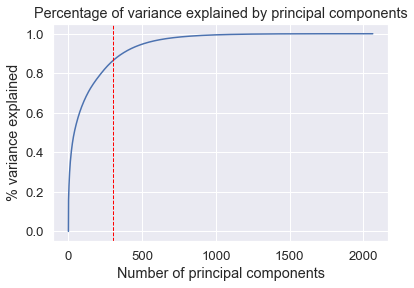

In [144]:
p = sns.lineplot(x=range(len(explained_var_sums)), y=explained_var_sums)
p.set_xlabel("Number of principal components")
p.set_ylabel("% variance explained")
p.set_title("Percentage of variance explained by principal components")
p.axvline(x=300, ls="--", c="red", lw=1)

In [357]:
explained_var_sums[850]

0.9891466238564873

In [359]:
explained_var_sums[3]

0.21356941146285835

Now, I will cast those list representation values to be numpy arrays so I can preprocess them easily. Further, I will normalize each array.

*side note: `preprocessing.normalize` vs `standardscaler`*

In [146]:
preprocessing.normalize(np.array([[1,100,2,3],[2,50,100,10]]))

array([[0.00999301, 0.99930073, 0.01998601, 0.02997902],
       [0.01781459, 0.44536472, 0.89072943, 0.08907294]])

In [147]:
scaler = StandardScaler()
scaler.fit_transform(np.array([[1,100,2,3],[2,50,100,10],[2,50,100,10]]))

array([[-1.41421356,  1.41421356, -1.41421356, -1.41421356],
       [ 0.70710678, -0.70710678,  0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678,  0.70710678,  0.70710678]])

Now I'm thinking, should I *normalize* or *standardize*?

In [148]:
# for ns in ns_sr_rep:
#     rep = ns_sr_rep[ns]
#     ns_sr_rep[ns] = preprocessing.normalize(np.array([rep]))

## Visualizing PCA

In [149]:
# ns_repr_new = fit1.transform(MaxAbsScaler().fit_transform(np.array(ns_repr))) #fit1 is PCA
ns_repr_new = fit1.transform(StandardScaler().fit_transform(np.array(ns_repr))) #fit1 is PCA

In [150]:
x = [k[0] for k in ns_repr_new]
y = [k[1] for k in ns_repr_new]
z = [k[2] for k in ns_repr_new]

In [151]:
import plotly.express as px

In [152]:
df = pd.DataFrame({"pc1": x,
                   "pc2": y,
                   "pc3": z,
                   # "pc4": a,
                   "source": ns_fixed_})

fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3', 
                    # color='pc4',
                    hover_name='source', opacity=0.4,
                   title = "First three principal components")
fig.update_traces(marker_size = 3)

fig.show()

## K-Means

Without and with standardization.

First, I need to find optimum `k`.

In [153]:
type(ns_repr_new)

numpy.ndarray

In [154]:
len(ns_repr_new[0])

2064

In [155]:
old_ns_repr_new = ns_repr_new.tolist()

In [156]:
# newssource_rep_dict_850 = dict()

# for ii in range(len(ns_fixed_)):
#     newssource_rep_dict_850[ns_fixed_[ii]] = [k[:850] for k in old_ns_repr_new]

In [157]:
# json.dump(newssource_rep_dict_850, open("newssource_rep_dict_850.json","w"))

In [158]:
ns_repr_new = [k[:100] for k in ns_repr_new]

In [159]:
kmeans = KMeans(init = "k-means++",
               n_clusters = 100,
               n_init = 10,
               max_iter = 500)

Freezing the list for representations and the news sources.

In [160]:
kmeans.fit([v for v in ns_repr_new])

KMeans(max_iter=500, n_clusters=100)

In [161]:
ns_fixed = list(ns_sr_rep.keys())

In [162]:
for i,ns in enumerate(ns_fixed):
    if (ns_sr_rep[ns] == ns_repr[i]).all():
        pass
    else:
        print("False")
print("True")

True


In [163]:
kmeans.inertia_

498759.35383502726

In [164]:
kmeans.n_iter_

15

In [165]:
Counter(kmeans.labels_)

Counter({1: 2203,
         36: 155,
         22: 1,
         99: 33,
         31: 1,
         20: 2,
         7: 1,
         53: 9,
         60: 7,
         11: 3,
         56: 1,
         15: 8,
         52: 1,
         71: 7,
         96: 3,
         95: 6,
         0: 15,
         24: 1,
         88: 5,
         27: 12,
         84: 1,
         48: 1,
         92: 3,
         63: 4,
         34: 1,
         28: 6,
         38: 6,
         69: 10,
         26: 3,
         58: 4,
         18: 3,
         54: 2,
         41: 2,
         94: 6,
         67: 3,
         68: 1,
         17: 1,
         57: 4,
         16: 1,
         9: 1,
         5: 1,
         79: 3,
         21: 1,
         90: 3,
         59: 4,
         49: 1,
         87: 5,
         66: 1,
         3: 1,
         70: 3,
         65: 1,
         33: 1,
         72: 3,
         80: 1,
         19: 1,
         45: 1,
         29: 1,
         39: 1,
         25: 1,
         74: 4,
         97: 1,
         44: 1,
     

**Choosing the appropriate number of clusters**

1. Elbow method

In [166]:
kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 360
}

In [167]:
sse = []
sc = []
chs = [] # bigger better
dbs = []

for k in range(2,101):
    kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
    kmeans.fit(preprocessing.normalize(np.array(ns_repr_new)))
    sse.append(kmeans.inertia_)
    score = silhouette_score(preprocessing.normalize(np.array(ns_repr_new)), kmeans.labels_)
    sc.append(score)
    chs_score = metrics.calinski_harabasz_score(preprocessing.normalize(np.array(ns_repr_new)), kmeans.labels_)
    chs.append(chs_score)
    dbs_score = metrics.davies_bouldin_score(preprocessing.normalize(np.array(ns_repr_new)), kmeans.labels_)
    dbs.append(dbs_score)
    print(f"have done {k} rounds, current sse is {sse}")

have done 2 rounds, current sse is [1754.2360940756705]
have done 3 rounds, current sse is [1754.2360940756705, 1699.0486951861392]
have done 4 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055]
have done 5 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368]
have done 6 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641]
have done 7 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914]
have done 8 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415]
have done 9 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.6352556

have done 29 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857]
have done 30 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.82554

have done 41 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176]
have done 42 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.66731562

have done 51 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.0979662

have done 59 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.0979662

have done 66 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.0979662

have done 73 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.0979662

have done 79 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.0979662

have done 85 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.0979662

have done 90 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.0979662

have done 95 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.0979662

have done 100 rounds, current sse is [1754.2360940756705, 1699.0486951861392, 1666.3328548612055, 1636.5509269800368, 1605.4771842819641, 1578.7552335874914, 1542.6673156280415, 1524.635255616871, 1506.7136676371306, 1481.4658244985721, 1458.1176064984418, 1430.9352014276294, 1413.0747120008732, 1396.8414184981377, 1372.8792355807511, 1360.4627718946253, 1342.0120934632305, 1327.6732483949709, 1317.8255461527244, 1294.723665198957, 1284.329402589845, 1267.1768904811368, 1250.5507862759885, 1232.3434436871034, 1222.1405823911782, 1210.6847777020805, 1199.2810130502369, 1184.3201856494857, 1176.646550988622, 1167.6016782832644, 1156.3472438776055, 1143.6534829656873, 1136.5158197236744, 1127.1142436999921, 1120.538641198265, 1110.8523576253344, 1094.5790206453203, 1088.3458835800595, 1081.183426422843, 1072.428357297176, 1064.5975675690177, 1056.333664231452, 1051.6207945464919, 1038.7573826990192, 1033.215842346102, 1026.3280139273625, 1018.4456968026049, 1011.9279191708997, 1001.097966

Text(0, 0.5, 'WGSS')

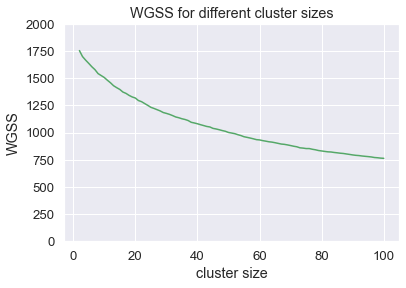

In [168]:
plt.plot(range(2,101),sse,"g-")
plt.ylim([0,2000])
plt.title("WGSS for different cluster sizes")
plt.xlabel("cluster size")
plt.ylabel("WGSS")

In [169]:
kl = KneeLocator(range(2,101), sse, curve="convex", direction="decreasing")

In [170]:
kl.elbow

38

### Silhouette Coefficient

In [171]:
px.scatter(x=range(2, 101), y=sc)

Text(0, 0.5, 'silhouette coefficient value')

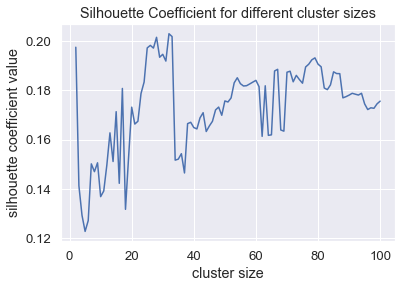

In [172]:
# for silhouette coefficient
plt.plot(range(2,101), sc, "b-")
plt.title("Silhouette Coefficient for different cluster sizes")
plt.xlabel("cluster size")
plt.ylabel("silhouette coefficient value")

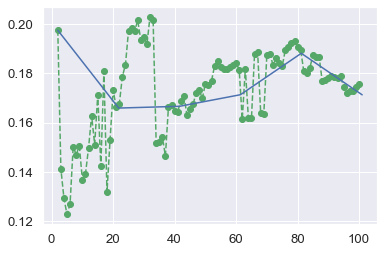

In [173]:
    spl = make_interp_spline(range(2,101), sc, k=3)  # type: BSpline

    xs = np.linspace(2, 101, 6)
    ys = spl(xs)

    plt.plot(range(2,101), sc, "go--")
    plt.plot(xs, ys, "b-")

### CHS

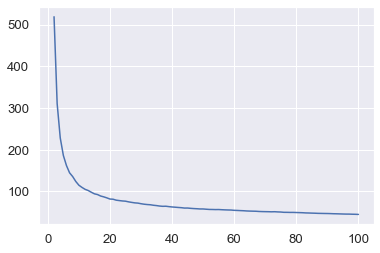

In [174]:
plt.plot(range(2,101), chs)

### DBS

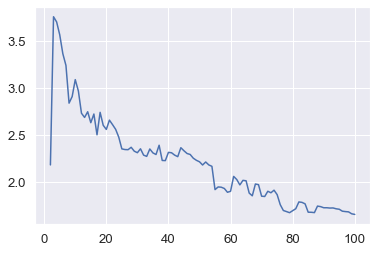

In [175]:
plt.plot(range(2, 101), dbs)

Let's choose k = 10

In [303]:
kmeans = KMeans(n_clusters = 28, init="k-means++", n_init = 50, max_iter = 500, random_state = 360)
# kmeans = KMeans(n_clusters = 10, init="random", n_init = 50, max_iter = 500, random_state = 360)

kmeans.fit(preprocessing.normalize(np.array(ns_repr_new)))

KMeans(max_iter=500, n_clusters=28, n_init=50, random_state=360)

In [304]:
kmeans.labels_

array([13,  1,  1, ...,  1,  7,  1])

In [245]:
set(kmeans.labels_)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27}

In [305]:
Counter(kmeans.labels_)

Counter({13: 221,
         1: 935,
         19: 35,
         14: 42,
         5: 28,
         12: 53,
         10: 181,
         4: 226,
         17: 53,
         15: 40,
         16: 23,
         9: 48,
         0: 45,
         22: 32,
         18: 60,
         6: 77,
         20: 59,
         21: 61,
         3: 42,
         11: 42,
         7: 79,
         2: 57,
         8: 49,
         27: 36,
         26: 38,
         25: 27,
         23: 22,
         24: 28})

**Let's investigate each cluster**

In [306]:
len(ns_sr_rep)

2639

In [307]:
len(kmeans.labels_)

2639

In [308]:
clustered = defaultdict(list)
for idx,ns in enumerate(non_outlier):
    c = kmeans.labels_[idx]
    clustered[c].append(ns)

In [309]:
print([len(clustered[i]) for i in range(len(set(kmeans.labels_)))])

[45, 935, 57, 42, 226, 28, 77, 79, 49, 48, 181, 42, 53, 221, 42, 40, 23, 53, 60, 35, 59, 61, 32, 22, 28, 27, 38, 36]


Let's see in terms of percentage

In [310]:
cluster_lens = [len(clustered[i]) for i in range(len(set(kmeans.labels_)))]

In [311]:
print([round(k*100/sum(cluster_lens),2) for k in cluster_lens])

[1.71, 35.43, 2.16, 1.59, 8.56, 1.06, 2.92, 2.99, 1.86, 1.82, 6.86, 1.59, 2.01, 8.37, 1.59, 1.52, 0.87, 2.01, 2.27, 1.33, 2.24, 2.31, 1.21, 0.83, 1.06, 1.02, 1.44, 1.36]


In [312]:
611/len(ns_fixed)

0.2315270935960591

 **could do iterative clusters for ^**

In [314]:
clustered[0]

['montrealgazette.com',
 'toronto.ctvnews.ca',
 'tsn.ca',
 'ipolitics.ca',
 'dailyhive.com',
 'theglobeandmail.com',
 'nationalobserver.com',
 'torontosun.com',
 'calgaryherald.com',
 'pressprogress.ca',
 'wealthsimple.com',
 'globalnews.ca',
 'tvo.org',
 'ctvnews.ca',
 'nationalpost.com',
 'citynews.ca',
 'edmontonjournal.com',
 'ottawa.ctvnews.ca',
 'macleans.ca',
 'financialpost.com',
 'thespec.com',
 'blogto.com',
 'vancouversun.com',
 '680news.com',
 'leaderpost.com',
 'nowtoronto.com',
 'toronto.citynews.ca',
 'castanet.net',
 'ottawacitizen.com',
 'cbc.ca',
 'canadiandimension.com',
 'montreal.ctvnews.ca',
 'narcity.com',
 'cp24.com',
 'thetyee.ca',
 'calgary.ctvnews.ca',
 'edmonton.ctvnews.ca',
 'vancouverisawesome.com',
 'thebeaverton.com',
 'winnipegfreepress.com',
 'winnipeg.ctvnews.ca',
 'bc.ctvnews.ca',
 'citynews1130.com',
 'straight.com',
 'thestar.com']

In [315]:
len(ns_fixed)

2639

In [316]:
ss = metrics.silhouette_samples(preprocessing.normalize(np.array(ns_repr_new)), kmeans.labels_, metric='euclidean')

In [317]:
label2ss = defaultdict(list)
for ii in range(len(ns_fixed)):
    label2ss[kmeans.labels_[ii]].append(ss[ii])

In [318]:
len(label2ss)

28

In [319]:
from matplotlib.pyplot import figure

Text(0, 0.5, 'sillouette coefficient value')

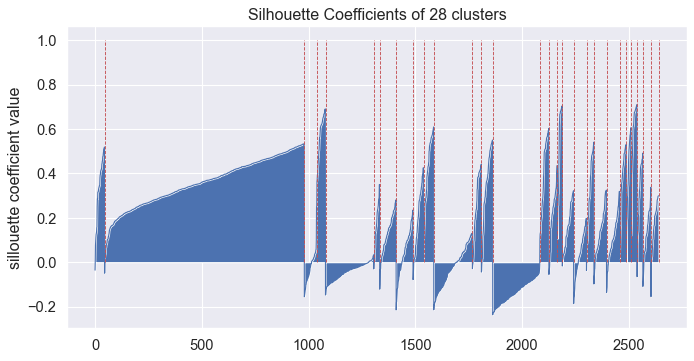

In [320]:
figure(figsize=(10, 5), dpi=80)

scs = []
for k in range(len(label2ss)):
    scs += sorted(label2ss[k])

plt.plot(range(len(ns_fixed)), scs, '-', linewidth=1, fillstyle='bottom')

cumulative = 0
for k in range(len(set(kmeans.labels_))):
    plt.plot([cumulative + len(label2ss[k]), cumulative + len(label2ss[k])], [0,1], 'r--', linewidth=0.8)
    cumulative += len(label2ss[k])
    
# plt.plot([11,11], [0,0.8], 'r')
# plt.plot([22,22], [0,0.8], 'r')
plt.fill_between(range(len(ns_fixed)), scs, 0)
plt.title("Silhouette Coefficients of 28 clusters")
plt.ylabel("sillouette coefficient value")

In [321]:
means = [statistics.mean(label2ss[k]) for k in range(len(set(kmeans.labels_)))]
len(means)

28

In [327]:
for k in range(len(means)):
    print(f"{k+1}: {means[k]}")

1: 0.33409753901615635
2: 0.3578623874220103
3: -0.03181264168178359
4: 0.5614932972488815
5: -0.044052849522744054
6: 0.17079523194485852
7: 0.12750319674150812
8: 0.040023090441041256
9: 0.19241151006247584
10: 0.4166639963208803
11: -0.027316875449746505
12: 0.26247466763464256
13: 0.339519363297935
14: -0.13633671457833937
15: 0.404819260510347
16: 0.21448477584268294
17: 0.5301463628802657
18: 0.1586705537074962
19: 0.032844938284599154
20: 0.3214432507805861
21: 0.13343359481058814
22: 0.10343842025957736
23: 0.36787769204905235
24: 0.40917384872755325
25: 0.5711551987667955
26: 0.3139989577805207
27: 0.12438409901868225
28: 0.16640723727254966


In [356]:
clustered[27]

['deseret.com',
 'azfamily.com',
 'courant.com',
 'kob.com',
 'fox13now.com',
 'eastidahonews.com',
 'ktar.com',
 'azcentral.com',
 'hcn.org',
 'biologicaldiversity.org',
 'ky3.com',
 'nativenewsonline.net',
 'krqe.com',
 'citizen-times.com',
 'kjzz.org',
 'kold.com',
 'ksl.com',
 'wlos.com',
 'kutv.com',
 'abc4.com',
 'alaskapublic.org',
 'religionnews.com',
 'byu.edu',
 'tucson.com',
 'abc15.com',
 'abqjournal.com',
 'fox10phoenix.com',
 'utah.gov',
 'santafenewmexican.com',
 'eenews.net',
 'indiancountrytoday.com',
 '12news.com',
 'azmirror.com',
 'adn.com',
 'phoenixnewtimes.com',
 'sltrib.com']

In [329]:
pctgs = [round(k*100/sum(cluster_lens),2) for k in cluster_lens]
for k in range(len(pctgs)):
    print(f"{k+1}: {pctgs[k]}")

1: 1.71
2: 35.43
3: 2.16
4: 1.59
5: 8.56
6: 1.06
7: 2.92
8: 2.99
9: 1.86
10: 1.82
11: 6.86
12: 1.59
13: 2.01
14: 8.37
15: 1.59
16: 1.52
17: 0.87
18: 2.01
19: 2.27
20: 1.33
21: 2.24
22: 2.31
23: 1.21
24: 0.83
25: 1.06
26: 1.02
27: 1.44
28: 1.36


# Agglomerative (Hierarchical) Clustering

In [192]:
hclustering = AgglomerativeClustering(n_clusters=15)

In [193]:
hclustering.fit(ns_repr_new)

AgglomerativeClustering(n_clusters=15)

In [194]:
hclustering.labels_

array([0, 0, 0, ..., 0, 5, 0], dtype=int64)

In [195]:
hier_clustered = defaultdict(list)
for idx,ns in enumerate(non_outlier):
    c = hclustering.labels_[idx]
    hier_clustered[c].append(ns)

In [196]:
print([len(hier_clustered[i]) for i in range(15)])

[2602, 2, 6, 2, 1, 12, 2, 1, 2, 1, 1, 1, 1, 2, 3]


Let's see in terms of percentage

In [197]:
hcluster_lens = [len(hier_clustered[i]) for i in range(10)]

In [198]:
print([round(k*100/sum(hcluster_lens),2) for k in hcluster_lens])

[98.9, 0.08, 0.23, 0.08, 0.04, 0.46, 0.08, 0.04, 0.08, 0.04]


In [199]:
hier_clustered[14]

['deadline.com', 'variety.com', 'hollywoodreporter.com']

In [200]:
set(hier_clustered[0]) & set(clustered[4])

set()

## Visualizing PCA in 2D using tSNE

t-sne scales quadratically but perhaps we can run tSNE after PCA

In [201]:
from sklearn.manifold import TSNE

In [202]:
twodpca = TSNE(n_components=3, perplexity=75)

In [203]:
twodpca.get_params()

{'angle': 0.5,
 'early_exaggeration': 12.0,
 'init': 'random',
 'learning_rate': 200.0,
 'method': 'barnes_hut',
 'metric': 'euclidean',
 'min_grad_norm': 1e-07,
 'n_components': 3,
 'n_iter': 1000,
 'n_iter_without_progress': 300,
 'n_jobs': None,
 'perplexity': 75,
 'random_state': None,
 'verbose': 0}

In [204]:
from datetime import datetime

In [205]:
# fit2 = twodpca.fit_transform(MaxAbsScaler().fit_transform(np.array(ns_repr)))
# fit2 = twodpca.fit_transform(StandardScaler().fit_transform(np.array(ns_repr)))
print(datetime.now())
fit2 = twodpca.fit_transform(ns_repr_new)
print(datetime.now())

2022-04-15 17:42:59.428917
2022-04-15 17:43:34.201188


In [206]:
len(ns_repr_new[0])

100

In [207]:
# json.dump(fit2.tolist(), open("tsne_3d.json", "w"))

In [208]:
x = [k[0] for k in fit2]
y = [k[1] for k in fit2]
z = [k[2] for k in fit2]
# a = [k[3] for k in fit2]

Idea: show only news sources that are close to a particular news source

In [209]:
import plotly.express as px
import pandas

ns_fixed = list(ns_sr_rep.keys())

df = pandas.DataFrame({"pc1": x,
                   "pc2": y,
                   "pc3": z,
                   # "pc4": a,
                   "source": ns_fixed})

fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3', 
                    # color='pc4',
                    hover_name='source', opacity=0.4)
fig.update_traces(marker_size = 3)

fig.show()

In [210]:
?px.scatter_3d

In [211]:
len(ns_repr_new)

2639

In [212]:
len(srs)

1032

In [213]:
len(ns_repr_new[0])

100

## Clustering evaluation

1. With all ns_intersection that are not outliers using subreddits that are not outliers => one cluster has almost everything.

In [214]:
# closer to 1 better
metrics.silhouette_score(ns_repr_new, kmeans.labels_, metric='euclidean', sample_size=3000)

# With all ns_union that are not outliers using subreddits that are not outliers => one cluster has almost everything.
# 8k news sources, _ subreddits, _ PCs
# 0.8726470867482576

# With all ns_intersection that are not outliers (th = 10) using subreddits that are not outliers (th = 100) => one cluster has almost everything.
# 7060 news sources, 2662 subreddits, 100 PCs, 10 clusters
# 0.9426717858025625

# With ns_intersection that are not outliers (th = 50) using subreddits that are not outliers (th = 100) => one cluster has almost everything.
# 2643 news sources, 1035 subreddits, 100 PCs, 10 clusters
# 0.8429645622533072

0.8425520981901823

In [215]:
# higher better
metrics.calinski_harabasz_score(ns_repr_new, kmeans.labels_)

# With all ns_intersection that are not outliers using subreddits that are not outliers => one cluster has almost everything.
# 8k news sources, _ subreddits, _ PCs
# 241.70519991875474

# With all ns_intersection that are not outliers (th = 10) using subreddits that are not outliers (th = 100) => one cluster has almost everything.
# 7060 news sources, 2662 subreddits, 100 PCs, 10 clusters
# 413.048982936904

# With ns_intersection that are not outliers (th = 50) using subreddits that are not outliers (th = 100) => one cluster has almost everything.
# 2643 news sources, 1035 subreddits, 100 PCs, 10 clusters
# 173.15845316896892

172.96851010113247

In [216]:
# closer to 0 better
metrics.davies_bouldin_score(ns_repr_new, kmeans.labels_)

# With all ns_intersection that are not outliers using subreddits that are not outliers => one cluster has almost everything.
# _ news sources, _ subreddits, _ PCs
# 1.3213014502791194

# With all ns_intersection that are not outliers (th = 10) using subreddits that are not outliers (th = 100) => one cluster has almost everything.
# 7060 news sources, 2662 subreddits, 100 PCs, 10 clusters
# 0.8011239006104709

# With ns_intersection that are not outliers (th = 50) using subreddits that are not outliers (th = 100) => one cluster has almost everything.
# 2643 news sources, 1035 subreddits, 100 PCs, 10 clusters
# 1.1818729937229002

1.2053104598979372

Insights

1. K-means suffers from high dimensionality, but just simply filtering for news sources with the most information and subreddits with the most news sources does not make clustering better. Perhaps should really filter for subreddits that are relevant.
2. After visualizing, the clusters that appear do make sense. t-SNE after PCA is a good idea. We will need further work to extract this. But with t-SNE you cannot interpret the distance between clusters A and B at different ends of your plot. t-SNE only for vis.
3. From the PCA then tSNE, we see that yes we can infer news source characteristics using audience-based metrics.
4. I should leave clustering here. Next step is to implement autoencoder for classifications.

### Let's see where our sport news are

In [217]:
# finding their indices

In [218]:
sport_news = json.load(open("sports_cluster.json", "r"))
len(sport_news)

85

In [219]:
sport_news_idx = {}
for s in sport_news:
    try:
        sport_news_idx[s] = ns_fixed.index(s)
    except ValueError:
        pass

In [220]:
len(sport_news_idx)

69

In [221]:
# build their representation
sport_news_repr = {}
for s in sport_news_idx:
    sport_news_repr[s] = fit2[sport_news_idx[s]]

In [ ]:
sn_items = list(sport_news_repr.items())

sn_fixed = [k[0] for k in sn_items]

In [236]:
sports_colors = [str(sport_news[k]) for k in sn_fixed]

In [237]:
xs = [k[1][0] for k in sn_items]
ys = [k[1][1] for k in sn_items]
zs = [k[1][2] for k in sn_items]
# bs = [k[1][3] for k in sn_items]

In [238]:
df = pandas.DataFrame({"pc1": xs,
                   "pc2": ys,
                   "pc3": zs,
                   "source": sn_fixed,
                   "cluster": sports_colors})

fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3', 
                    color='cluster', 
                    hover_name='source', opacity=0.4)
fig.show()

In [225]:
len(ns_fixed)

2639

In [226]:
with open("ns_fixed.json", "w") as nsf:
    json.dump(ns_fixed, nsf)

In [227]:
len(ns_fixed) == len(ns_repr_new)

True

In [228]:
len(ns_repr_new[0])

100

In [229]:
type(fit2)

numpy.ndarray

In [230]:
fit2.tolist()[0]

[15.123294830322266, -18.877197265625, -8.158150672912598]